# Loading Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize, LabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#For performing hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
#Evaluation metrics

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Some Parallel Processing
import ray
ray.init(log_to_driver = False, num_cpus = 12)

2022-12-16 15:57:17,696	INFO worker.py:1528 -- Started a local Ray instance.


Python version:,3.9.12
Ray version:,2.1.0


# Data Processing

## Missing Data

*Note From Our Expert- Dr. Joseph Hora (Elizabeth's Dad):*

For sources that do not have entries for their magnitude, you can assume that the values are greater than the following levels for the various filters:



W1  > 17.3

W2  > 18.4

W3  > 15.7

W4  > 10.2

J      > 19.2

H     > 18.0

K     > 17.1

GaiaDR3_G > 22.1

GaiaDR3_B > 24.6

GaiaDR3_R > 21.0



Remember that for magnitudes, larger values mean fainter objects.

*Interpretation from Elizabeth Hora:*

If the objects are too faint to see (the magnitude is too low for a particular band to detect), then I can keep the measurements by assigning a value that is slightly below the cutoff point for detection. Imputing the mean would not be good here because I know that for example, if an object cannot be detected in the H band, it must have a magnitude greater than 18. If I impute a value such as 20, then only the objects who were not able to be detected would have a value of 20. This allows us to keep this information without distorting the other information in the dataset. We applied this approach for all bands.

In [2]:
# Reading in DataSet
whole_truth = pd.read_csv("truth_set.csv")

whole_truth_no_nas = whole_truth.dropna(axis = 0)

# Imputing values for "NA"- not really missing,
# but not there by design (too dim to be read)
whole_truth["W1"] = whole_truth["W1"].fillna(19)
whole_truth["W2"] = whole_truth["W2"].fillna(20)
whole_truth["W3"] = whole_truth["W3"].fillna(17)
whole_truth["W4"] = whole_truth["W4"].fillna(12)
whole_truth["J"] = whole_truth["J"].fillna(21)
whole_truth["H"] = whole_truth["H"].fillna(20)
whole_truth["K"] = whole_truth["K"].fillna(19)
whole_truth["GaiaDR3_G"] = whole_truth["GaiaDR3_G"].fillna(24)
whole_truth["GaiaDR3_B"] = whole_truth["GaiaDR3_B"].fillna(26)
whole_truth["GaiaDR3_R"] = whole_truth["GaiaDR3_R"].fillna(23)

x_cols = []
for col in whole_truth.columns.to_list():
    if "TYPE" not in col:
        x_cols.append(col)
y_col = ["SP_TYPE"]
x_train, x_test, y_train, y_test = train_test_split(
    whole_truth[x_cols], 
    whole_truth[y_col], 
    test_size = 0.2, 
    random_state=1009
)

In [3]:
whole_truth_dist = pd.merge(x_train.reset_index(), y_train.reset_index()).drop(columns = "index")

## Defining a Predictor Variable

In this project, we are not going to go down to a super detailed level where we are trying to tell the difference between a C-star, an O-AGB, or a C-AGB star (all types of AGB stars). Instead, we will take the first step and separate the three main classes of stars. This is analogous to having a dataset with different species of cats, lizards, and fish. Instead of telling the difference between a mainecoon and a piranha, if we first separate all the cats, lizards, and fish into distinct groups, it makes the classification process less complicated. We are therefore doing the first step in an ensemble model approach.

**Main Families:**
- Young: Young Stellar Objects (YSOs)
- Middle Aged: Main Sequence Stars (MS)
- Old: Asymptotic Giant Branch Stars (AGBs)

We will convert all the subtypes into main groups via a `family_class()` function. These data will have a class imbalance due to the definition of each main family. YSOs are within the first million years or so of a stars life, and AGB stars happen in the last tens of millions of years or so of a stars life. However, stars have a lifespan that can stretch into the Gigayears (millions of millions). Therefore, the MS category will most definitely outnumber the YSOs and AGBs combined due to how stars progress through their life cycle.

In [4]:
def family_class(i_name):
    agb_stars = ["c-star", "o-agb", "c-agb"]
    
    if i_name[:3].lower() == "yso":
        return "YSO"
    elif i_name.lower() == "ms":
        return "MS"
    elif i_name.lower() in agb_stars:
        return "AGB"

In [5]:
whole_truth_dist["main_family"] = whole_truth_dist["SP_TYPE"].apply(lambda row: family_class(row))
whole_truth_dist

,designation,ra,dec,Av,W1,W2,W3,W4,J,H,...,Kerr,GaiaDR3_G,GaiaDR3_Gerr,GaiaDR3_B,GaiaDR3_Berr,GaiaDR3_R,GaiaDR3_Rerr,Dist,SP_TYPE,main_family
0,J052200.54-694519.2,80.502261,-69.755359,20.0,12.3630,11.844,11.099,7.998,21.0000,14.4910,...,0.023,24.000000,0.023211,26.000000,0.074305,23.000000,0.054373,0.000000,MS,MS
1,J062314.71+134235.0,95.811328,13.709729,2.0,11.3930,11.394,11.900,9.119,12.0600,11.6830,...,0.020,14.051610,0.002935,14.448630,0.003025,13.121870,0.003908,0.000000,MS,MS
2,J191031.61+501748.2,287.631744,50.296745,7.0,11.4450,11.395,11.606,8.795,13.7290,12.2840,...,0.026,19.448164,0.002768,26.000000,0.003315,17.198946,0.003855,203.509700,MS,MS
3,J193437.30+480641.6,293.655423,48.111583,0.0,12.3650,12.386,12.691,9.621,12.6930,12.4520,...,0.025,13.656930,0.002767,13.946073,0.002871,13.203865,0.003854,1266.243200,MS,MS
4,J195412.37+185059.8,298.551543,18.849967,12.0,11.1210,11.085,11.582,8.557,14.3630,12.4370,...,0.021,24.000000,0.002807,26.000000,0.003133,19.554991,0.003855,0.000000,MS,MS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306210,J054147.02-014926.7,85.445955,-1.824087,NaN,10.2910,9.612,6.997,1.629,13.1360,11.7470,...,0.019,17.606638,0.003955,19.858866,0.168387,16.196512,0.012357,278.023193,YSO-D,YSO
306211,J055541.06+251547.9,88.921095,25.263306,0.5,10.5765,10.595,10.807,8.699,11.2305,10.7505,...,0.021,12.946856,0.002765,13.520269,0.002882,12.214282,0.003831,766.963500,MS,MS
306212,J085116.81+114541.0,132.820058,11.761404,14.0,12.3160,12.228,13.168,8.671,16.2580,14.3390,...,0.023,24.000000,0.002761,26.000000,0.002951,23.000000,0.003987,793.141000,MS,MS
306213,J190916.61+495631.6,287.319224,49.942111,14.0,12.9020,12.771,13.134,9.432,16.1930,14.2860,...,0.025,24.000000,0.002767,26.000000,0.002946,23.000000,0.003839,664.009500,MS,MS


## Filtering out Stars with Unknown Distance

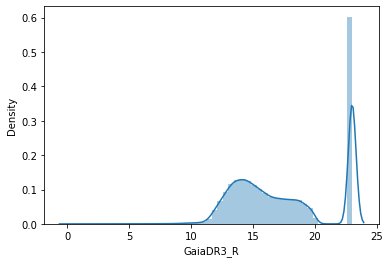

In [6]:
sns.distplot(whole_truth_dist["GaiaDR3_R"]);

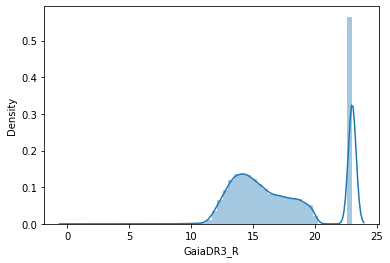

In [7]:
sns.distplot(whole_truth_dist[
    (~np.isnan(np.array(whole_truth_dist["Dist"])))
    ]["GaiaDR3_R"]
);

There does not appear to be too radical of a change here when filtering out stars with an unknown distance (determined by the paralax of an object- if reliable measurements cannot be made, a distance value cannot be calculated). In this case, these values truly are missing, and there is no easy way to recover them. For the sake of simplicity, filtering them out will be the approach we take.

In [8]:
whole_truth_dist.dropna(subset = "Dist", inplace = True)

In [9]:
whole_truth_dist.shape

(273003, 27)

This is still a fairly large dataset without the missing distances.

In [10]:
whole_truth_dist

,designation,ra,dec,Av,W1,W2,W3,W4,J,H,...,Kerr,GaiaDR3_G,GaiaDR3_Gerr,GaiaDR3_B,GaiaDR3_Berr,GaiaDR3_R,GaiaDR3_Rerr,Dist,SP_TYPE,main_family
0,J052200.54-694519.2,80.502261,-69.755359,20.0,12.3630,11.844,11.099,7.998,21.0000,14.4910,...,0.023,24.000000,0.023211,26.000000,0.074305,23.000000,0.054373,0.000000,MS,MS
1,J062314.71+134235.0,95.811328,13.709729,2.0,11.3930,11.394,11.900,9.119,12.0600,11.6830,...,0.020,14.051610,0.002935,14.448630,0.003025,13.121870,0.003908,0.000000,MS,MS
2,J191031.61+501748.2,287.631744,50.296745,7.0,11.4450,11.395,11.606,8.795,13.7290,12.2840,...,0.026,19.448164,0.002768,26.000000,0.003315,17.198946,0.003855,203.509700,MS,MS
3,J193437.30+480641.6,293.655423,48.111583,0.0,12.3650,12.386,12.691,9.621,12.6930,12.4520,...,0.025,13.656930,0.002767,13.946073,0.002871,13.203865,0.003854,1266.243200,MS,MS
4,J195412.37+185059.8,298.551543,18.849967,12.0,11.1210,11.085,11.582,8.557,14.3630,12.4370,...,0.021,24.000000,0.002807,26.000000,0.003133,19.554991,0.003855,0.000000,MS,MS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306210,J054147.02-014926.7,85.445955,-1.824087,NaN,10.2910,9.612,6.997,1.629,13.1360,11.7470,...,0.019,17.606638,0.003955,19.858866,0.168387,16.196512,0.012357,278.023193,YSO-D,YSO
306211,J055541.06+251547.9,88.921095,25.263306,0.5,10.5765,10.595,10.807,8.699,11.2305,10.7505,...,0.021,12.946856,0.002765,13.520269,0.002882,12.214282,0.003831,766.963500,MS,MS
306212,J085116.81+114541.0,132.820058,11.761404,14.0,12.3160,12.228,13.168,8.671,16.2580,14.3390,...,0.023,24.000000,0.002761,26.000000,0.002951,23.000000,0.003987,793.141000,MS,MS
306213,J190916.61+495631.6,287.319224,49.942111,14.0,12.9020,12.771,13.134,9.432,16.1930,14.2860,...,0.025,24.000000,0.002767,26.000000,0.002946,23.000000,0.003839,664.009500,MS,MS


## Exploring Linear Relationships between Variables

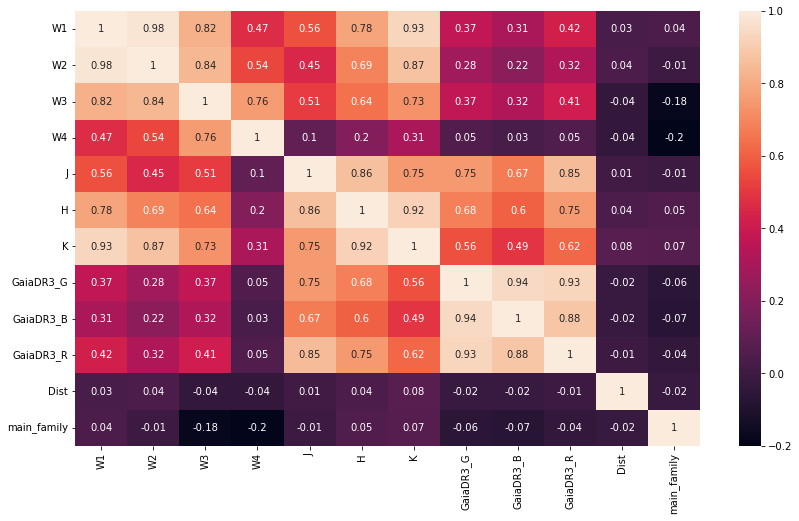

In [11]:
df1 = whole_truth_dist.copy()
df1 = df1.drop(["Av", 'ra','dec','SP_TYPE'],axis = 1)

cols = [i for i in df1.columns if i[-3:] != "err"]
df1 = df1[cols]

og_le = LabelEncoder()
og_le.fit(df1["main_family"])
df1["main_family"] = og_le.transform(df1["main_family"])


plt.figure(figsize = [14,8])
corr_matrix = df1.corr().round(2)
sns.heatmap(corr_matrix, annot = True) 
plt.show()

In our models, we could try running all variables and seeing how the performance is. However, bands like `W3`, `K`, and `GaiaDR3_B` all seem to be fairly correlated with the `main_family` predictor variable without being very correlated with each other (autocorrelation is likely not a huge concern here with only those 3 bands).

## Visualizing the Data

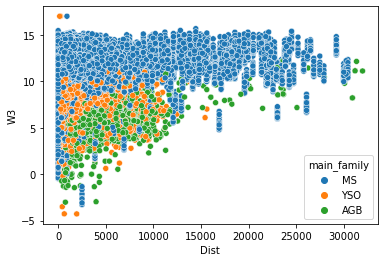

In [12]:
sns.scatterplot(
    data = whole_truth_dist,
    x = "Dist",
    y = "W3",
    hue = "main_family"
);

When plotting one of the bands (`W3`) with respect to Distance, there is no obvious pattern going on. To make matters worse, the three types of main families are on top of each other. When looking at 2-D combinations of other variables, the same problem is shown. This highlights the need for models to do this work because we as humans cannot do this by hand.

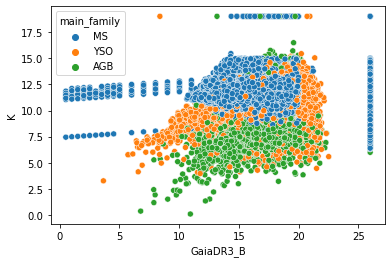

In [13]:
sns.scatterplot(
    data = whole_truth_dist,
    x = "GaiaDR3_B",
    y = "K",
    hue = "main_family"
);

# Running Models

## Overview

We are going to run the following models for all bands and a subset of bands (`W3`, `K`, and `GaiaDR3_B`):

- K-Nearest Neighbors
- Logistic Regression
- Support Vector Machine
- Random Forest

## K-Nearest Neighbors (KNN)

We chose to use the KNN algorithm because it is a classification algorithm that is effective in pattern recognition, and it works well with a very large training dataset. Before running the optimal KNN model, we found the 3 neighbors was the optimal value for k when comparing the testing dataset average accuracy across 5-folds. After running the KNN model with k=3, we found that the average accuracy of the model was about 98.97% for all predictors and 98.06% when only using three predictors (`W3`, `K`, and `GaiaDR3_B`). The MS classification had the highest accuracy out of the 3 different classes. In the KNN model, using all predictors was a slightly better strategy than only using 3 bands.

### All Bands

The accuracy is: 98.97%
Classification Report: 
              precision    recall  f1-score   support

         AGB       0.89      0.88      0.89       772
          MS       0.99      1.00      1.00     78647
         YSO       0.90      0.77      0.83      2482

    accuracy                           0.99     81901
   macro avg       0.93      0.88      0.90     81901
weighted avg       0.99      0.99      0.99     81901



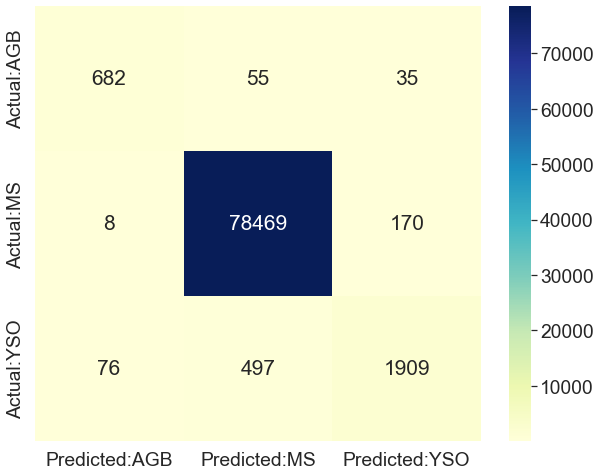

<Figure size 432x288 with 0 Axes>

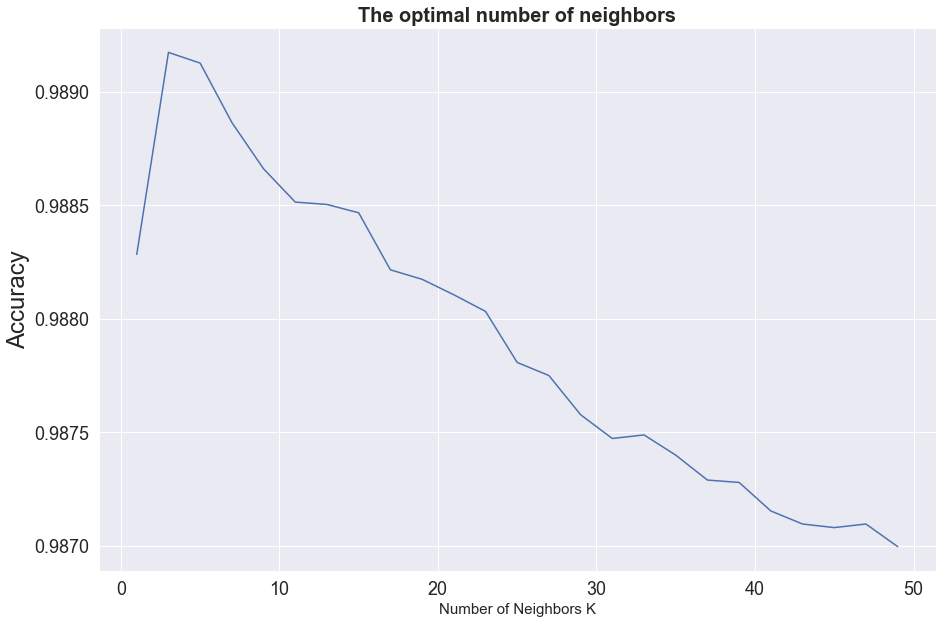

    k-values  cross validation score
0          1                0.988284
1          3                0.989173
2          5                0.989126
3          7                0.988865
4          9                0.988661
5         11                0.988514
6         13                0.988504
7         15                0.988467
8         17                0.988216
9         19                0.988174
10        21                0.988106
11        23                0.988033
12        25                0.987808
13        27                0.987750
14        29                0.987577
15        31                0.987473
16        33                0.987488
17        35                0.987399
18        37                0.987290
19        39                0.987279
20        41                0.987153
21        43                0.987096
22        45                0.987080
23        47                0.987096
24        49                0.986996
The optimal value of K is 3.


In [14]:
#define feature variables
x_data = df1[['W1','W2','W3','W4','J','H','K','GaiaDR3_G','GaiaDR3_B','GaiaDR3_R', "Dist"]]
#define target variable
y_data = df1['main_family']

le = LabelEncoder()
y_data = le.fit_transform(y_data)

#normalize feature variables
scaler = MinMaxScaler()
x_data_minmax = scaler.fit_transform(x_data)
data = pd.DataFrame(x_data_minmax,columns=['W1', 'W2', 'W3', 'W4','J','H','K','GaiaDR3_G','GaiaDR_B','GaiaDR_R',"Dist"])

data.head()

X_train, X_test, y_train, y_test = train_test_split(data, y_data,test_size=0.3, random_state = 0)
classifier=KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)

y_test_name = []
y_preds_name = []

for value in y_test:
    if value == 0:
        y_test_name.append("AGB")
    elif value == 1:
        y_test_name.append("MS")
    elif value == 2:
        y_test_name.append("YSO")
        
for value in y_pred:
    if value == 0:
        y_preds_name.append("AGB")
    elif value == 1:
        y_preds_name.append("MS")
    elif value == 2:
        y_preds_name.append("YSO")

accuracy = accuracy_score(y_test, y_pred)*100
print('The accuracy is: ' + str(round(accuracy, 2)) + '%')

print("Classification Report: ")
print(classification_report(y_test_name, y_preds_name))

sns.set(font_scale=1.75)
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=[
    'Predicted:AGB',
    'Predicted:MS',
    'Predicted:YSO'],
    index=[
        'Actual:AGB',
        'Actual:MS',
        'Actual:YSO'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.savefig("final_notebook_plots/knn_conf_mat.png", transparency = True)
plt.show()


k_list = list(range(1,50,2))
cv_scores = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
plt.figure()
plt.figure(figsize=(15,10))
plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Accuracy', fontsize=24)
sns.set_style("whitegrid")
plt.tick_params(axis='both', which='major', labelsize=18);

plt.plot(k_list, cv_scores)
plt.savefig("final_notebook_plots/knn_neighbor_selection.png", transparency = True)
plt.show()

data = {'k-values': k_list, 'cross validation score':cv_scores}
knn = pd.DataFrame(data)
print(knn)
print("The optimal value of K is 3.")

### 3 Bands

The accuracy is: 98.06%
Classification Report: 
              precision    recall  f1-score   support

         AGB       0.82      0.84      0.83       772
          MS       0.99      0.99      0.99     78647
         YSO       0.73      0.64      0.68      2482

    accuracy                           0.98     81901
   macro avg       0.84      0.83      0.83     81901
weighted avg       0.98      0.98      0.98     81901



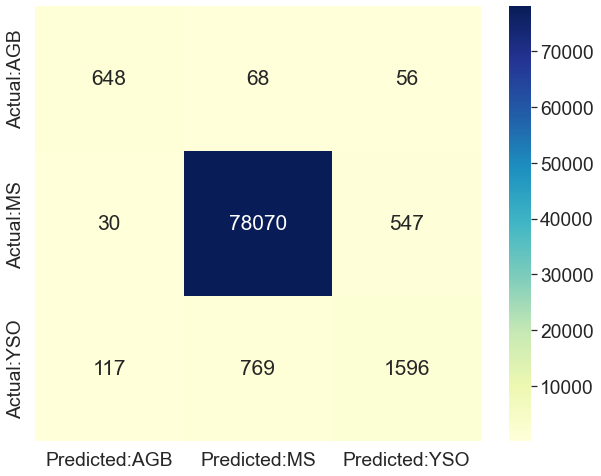

<Figure size 432x288 with 0 Axes>

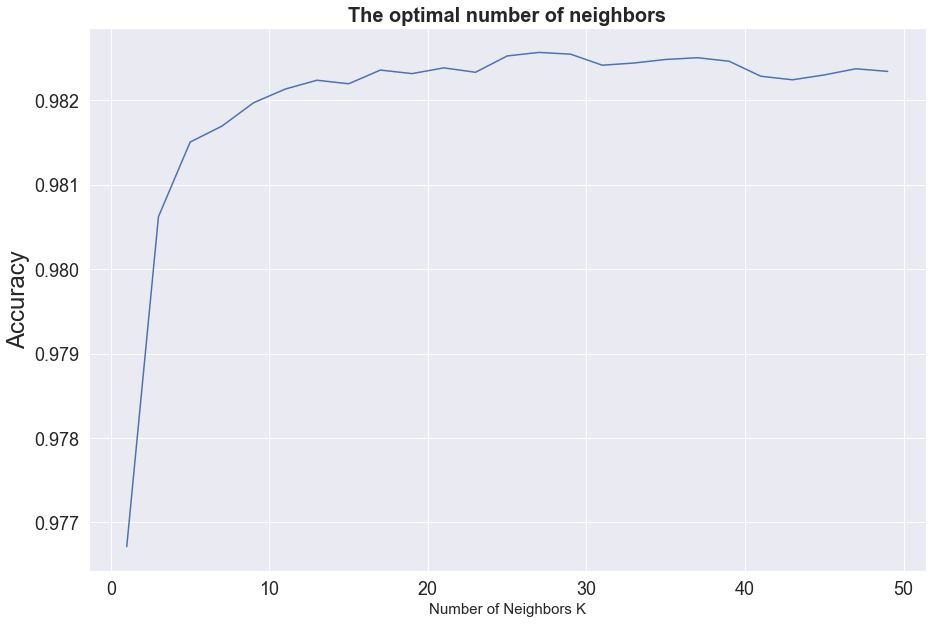

    k-values  cross validation score
0          1                0.976714
1          3                0.980623
2          5                0.981507
3          7                0.981696
4          9                0.981973
5         11                0.982135
6         13                0.982240
7         15                0.982198
8         17                0.982360
9         19                0.982318
10        21                0.982386
11        23                0.982334
12        25                0.982528
13        27                0.982570
14        29                0.982549
15        31                0.982418
16        33                0.982444
17        35                0.982486
18        37                0.982507
19        39                0.982465
20        41                0.982287
21        43                0.982245
22        45                0.982303
23        47                0.982376
24        49                0.982345
The optimal value of K is 3.


In [15]:
#define feature variables
x_data = df1[['W3','K','GaiaDR3_B']]
#define target variable
y_data = df1['main_family']

le = LabelEncoder()
y_data = le.fit_transform(y_data)

#normalize feature variables
scaler = MinMaxScaler()
x_data_minmax = scaler.fit_transform(x_data)
data = pd.DataFrame(x_data_minmax,columns=['W3','K','GaiaDR3_B'])

data.head()

X_train, X_test, y_train, y_test = train_test_split(data, y_data,test_size=0.3, random_state = 0)
classifier=KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)

y_test_name = []
y_preds_name = []

for value in y_test:
    if value == 0:
        y_test_name.append("AGB")
    elif value == 1:
        y_test_name.append("MS")
    elif value == 2:
        y_test_name.append("YSO")
        
for value in y_pred:
    if value == 0:
        y_preds_name.append("AGB")
    elif value == 1:
        y_preds_name.append("MS")
    elif value == 2:
        y_preds_name.append("YSO")

accuracy = accuracy_score(y_test, y_pred)*100
print('The accuracy is: ' + str(round(accuracy, 2)) + '%')

print("Classification Report: ")
print(classification_report(y_test_name, y_preds_name))

sns.set(font_scale=1.75)
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=[
    'Predicted:AGB',
    'Predicted:MS',
    'Predicted:YSO'],
    index=[
        'Actual:AGB',
        'Actual:MS',
        'Actual:YSO'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.savefig("final_notebook_plots/knn_conf_mat_3.png", transparency = True)
plt.show()


k_list = list(range(1,50,2))
cv_scores = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
plt.figure()
plt.figure(figsize=(15,10))
plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Accuracy', fontsize=24)
sns.set_style("whitegrid")
plt.tick_params(axis='both', which='major', labelsize=18);

plt.plot(k_list, cv_scores)
plt.savefig("final_notebook_plots/knn_neighbor_selection_3.png", transparency = True)
plt.show()

data = {'k-values': k_list, 'cross validation score':cv_scores}
knn = pd.DataFrame(data)
print(knn)
print("The optimal value of K is 3.")

## Logistic Regression

For logistic regression, before building the model, we put in a C-hyperparameter to filter out the unrelated features. C is the inverse regularization strength (a strong regularization strength reduces model complexity by reducing the number of predictors used). Using the cross-validation on subsets for 5-folds, we tested and picked the C-value that could provide us with the highest accuracy rate. We then used the ideal C-parameter in our final logistic model. These are our findings:
- The accuracy rate of three bands is 0.97.
- The accuracy rate of three bands is 0.968.

### All Bands

In [16]:
X = df1[['W1','W2','W3','W4','J','H','K','GaiaDR3_G','GaiaDR3_B','GaiaDR3_R', "Dist"]]
y = df1['main_family']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train = ray.put(X_train)
y_train = ray.put(y_train)

@ray.remote
def one_log_reg_run(i_x_tr, i_x_te, i_y_tr, i_y_te, ii_c):
    ### Cross-Validation in here
    logreg = LogisticRegression(C = ii_c, random_state = 42)
    logreg.fit(i_x_tr, i_y_tr)
    score = np.mean(cross_val_score(logreg, i_x_te, i_y_te, cv=5))
    
    return score
    
    

c_range = np.linspace(0, 1, num=30)
accuracy_list = []

for i_c in c_range:
    model_res = one_log_reg_run.remote(X_train, X_test, y_train, y_test, i_c)
    accuracy_list.append(model_res)
    
accuracy_list = ray.get(accuracy_list)    

In [17]:
reg_df = pd.DataFrame({"C":c_range, "Accuracy":accuracy_list})
reg_df = reg_df.sort_values("Accuracy", ascending = False)

ideal_c = np.array(reg_df.head(1)["C"])[0]
reg_df.head()

print("The ideal Regularization Parameter is: {}".format(ideal_c))

The ideal Regularization Parameter is: 0.48275862068965514


In [18]:
X = df1[['W1','W2','W3','W4','J','H','K','GaiaDR3_G','GaiaDR3_B','GaiaDR3_R', "Dist"]]
y = df1['main_family']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


logreg = LogisticRegression(C = ideal_c)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print("Test Accuracy: {}".format(round(accuracy_score(y_test, y_pred), 2)))

Test Accuracy: 0.96


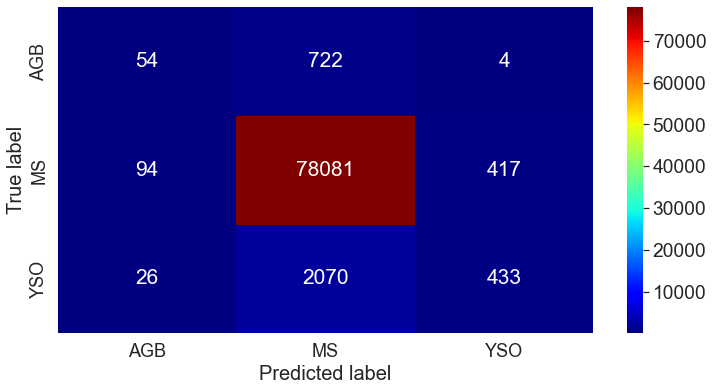

In [19]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(
    data=cm,
    columns=['AGB','MS','YSO'],
    index=['AGB','MS','YSO']
)
plt.figure(figsize = (12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="jet")
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig("final_notebook_plots/logreg_all_conf_mat.png", transparency = True)
plt.show()

### Using 3 Bands

In [20]:
X = df1[['W3','K','GaiaDR3_B']]
y =df1[['main_family']]

n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
c_range = np.linspace(0, 1, num=30)
accuracy_list = []

for i_c in c_range:
    ### Cross-Validation in here
    logreg = LogisticRegression(C = i_c, random_state = 42)
    accuracy_list.append(np.mean(cross_val_score(logreg, X_test, y_test, cv=5)))

In [22]:
reg_df = pd.DataFrame({"C":c_range, "Accuracy":accuracy_list})
reg_df = reg_df.sort_values("Accuracy", ascending = False)

ideal_c = np.array(reg_df.head(1)["C"])[0]
reg_df.head()
print("The ideal Regularization Parameter is: {}".format(ideal_c))

The ideal Regularization Parameter is: 0.5862068965517241


In [23]:
logreg = LogisticRegression(C = ideal_c)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

print("Test Accuracy: {}".format(round(accuracy_score(y_test, y_pred), 2)))

Test Accuracy: 0.97


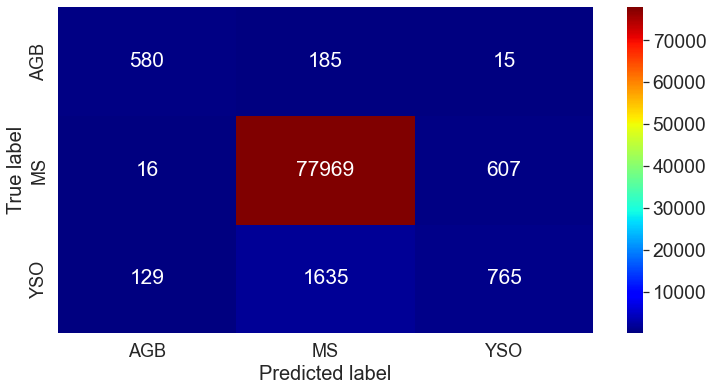

In [24]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(
    data=cm,
    columns=['AGB','MS','YSO'],
    index=['AGB','MS','YSO']
)
plt.figure(figsize = (12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="jet")
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig("final_notebook_plots/logreg_3_conf_mat.png", transparency = True)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       780
           1       0.98      0.99      0.98     78592
           2       0.55      0.30      0.39      2529

    accuracy                           0.97     81901
   macro avg       0.78      0.68      0.72     81901
weighted avg       0.96      0.97      0.96     81901



## Support Vector Machine (SVM)

**Beware, this section takes about 2 hours to run. **

For the support vector machine model, we used it because many discussion threads that I read about multi-class classification recommend it. An advantage of this model is that it allows us to change the kernel functions used to transform our data. For our data variables do not seem to be linearly related to each other (as seen in the correlation table in the section towards the beginning of the document). Such kernel functions include the likes of "linear", “radius basis function” or “polynomial” to transform the data points to make them linearly separable. At first we tried a linear kernel function, but that produced poor results. We then tried to use both polynomial and rabial basis function kernels with all bands and three bands’ data. Regardless of the situation, the outcome from “rbf” and “poly” were similar, therefore we will only include the rbf kernel function. In the SVM model, we binarized the three classes’ data points while the model to analyzed them as if they two classes by using the “OneVsRest” method (Also called One Versus All- OVA- in other contexts). This classifier takes an 'us versus them' approach and divided the data points in one class compared to everything else (the other two classes). Consecutively a specific class is distinguished from all other classes.

### All Bands

In [26]:
X = df1[['W1','W2','W3','W4','J','H','K','GaiaDR3_G','GaiaDR3_B','GaiaDR3_R', "Dist"]]
y = df1['main_family']

y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True,
                                 random_state=0))

y_score = classifier.fit(X_train, y_train).decision_function(X_test)

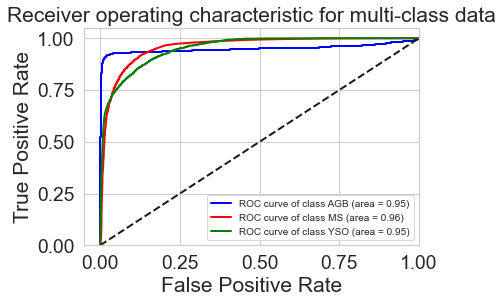

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

star_classes = ["AGB", "MS", "YSO"]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(star_classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.figure(figsize = (12,6))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right", prop={'size': 10})
plt.savefig("final_notebook_plots/svm_all_roc.png", transparency = True)
plt.show()

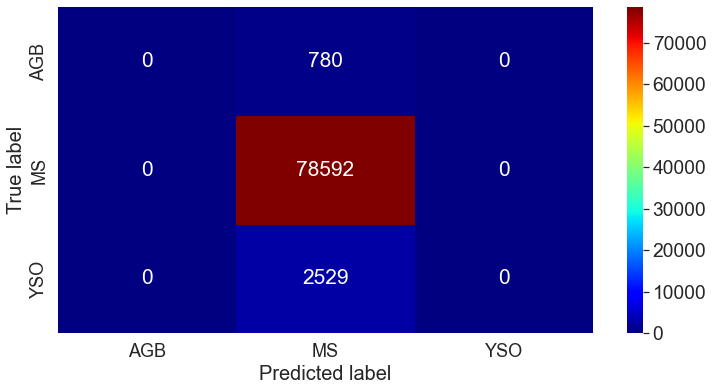

In [29]:
predictions = classifier.predict(X_test)

sns.set(font_scale=1.75)
cm = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))

conf_matrix=pd.DataFrame(
    data=cm,
    columns=['AGB','MS','YSO'],
    index=['AGB','MS','YSO']
)
plt.figure(figsize = (12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="jet")

plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.savefig("final_notebook_plots/svm_all_conf_mat.png", transparency = True)

plt.show()

In [30]:
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       780
           1       0.96      1.00      0.98     78592
           2       0.00      0.00      0.00      2529

    accuracy                           0.96     81901
   macro avg       0.32      0.33      0.33     81901
weighted avg       0.92      0.96      0.94     81901



This does not exactly match with the ROC Curve since we have not used the optimal threshold found in the ROC Curve to produce this confusion matrix. This outcome is poor because it is an always-MS classifier, which misses all cases of AGB and YSOs.

### 3 Bands

In [31]:
X = df1[['W3','K','GaiaDR3_B']]
y = df1[['main_family']]

y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [32]:
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True,
                                 random_state=0))

y_score = classifier.fit(X_train, y_train).decision_function(X_test)

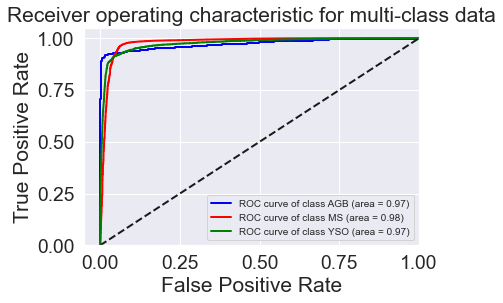

In [33]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

star_classes = ["AGB", "MS", "YSO"]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(star_classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')

plt.legend(loc="lower right", prop={'size': 10})

plt.figure(figsize = (12,6))

plt.savefig("final_notebook_plots/svm_3_roc.png", transparency = True)
plt.show()

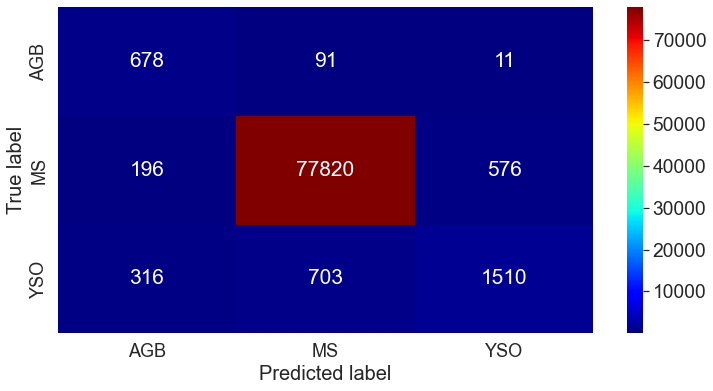

In [34]:
predictions = classifier.predict(X_test)

sns.set(font_scale=1.75)
cm = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
conf_matrix=pd.DataFrame(
    data=cm,columns=['AGB','MS','YSO'],
    index=['AGB','MS','YSO'])
plt.figure(figsize = (12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="jet")

plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.savefig("final_notebook_plots/svm_3_conf_mat.png")

plt.show()

In [35]:
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.57      0.87      0.69       780
           1       0.99      0.99      0.99     78592
           2       0.72      0.60      0.65      2529

    accuracy                           0.98     81901
   macro avg       0.76      0.82      0.78     81901
weighted avg       0.98      0.98      0.98     81901



## Random Forest

A random forest is a bagged decision tree method. The goal is to split data according to features and assign a class based on the makeup of where a new point ends after going through a decision tree. Theoretically, this method could be more equipped to handle class imbalances than other methods. I thought that changing the number of estimators (*n_estimators*; number of trees in the bagged forest), the maximum leaf nodes (*max_leaf_nodes*; grows trees in a best-first fashion, where the noes are defined according to the resulting classes of the split), and the maximum depth of each tree (*max_depth*; this can help the tree from getting too overfit).

### All Bands

In [36]:
X = df1[['W1','W2','W3','W4','J','H','K','GaiaDR3_G','GaiaDR3_B','GaiaDR3_R', "Dist"]]
y = df1[['main_family']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

list_i = []
list_j = []
list_k = []
list_accuracy = []

for i in range(50, 150, 30):
    for j in range(80, 120, 20):
        for k in range(1, 7, 2):
            list_i.append(i)
            list_j.append(j)
            list_k.append(k)
            
            rf_clf = RandomForestClassifier(
                random_state=42, 
                n_estimators = i, 
                max_leaf_nodes = j, 
                max_depth = k
            )
            rf_clf.fit(X_train, y_train)
            pred = rf_clf.predict(X_test)
            list_accuracy.append(np.mean(cross_val_score(rf_clf, X_test, y_test, cv=5)))

In [37]:
class_rf_df = pd.DataFrame({
    "n_estimators":list_i, 
    "max_leaf_nodes":list_j, 
    "max_depth":list_k, 
    "Accuracy":list_accuracy
}).sort_values("Accuracy", ascending = False)

class_rf_df.head(5)

,n_estimators,max_leaf_nodes,max_depth,Accuracy
23,140,100,5,0.984005
20,140,80,5,0.984005
8,80,80,5,0.983907
11,80,100,5,0.983907
14,110,80,5,0.983895


In [38]:
rf_clf = RandomForestClassifier(
    random_state=42, 
    n_estimators = class_rf_df["n_estimators"][0], 
    max_leaf_nodes = class_rf_df["max_leaf_nodes"][0], 
    max_depth = class_rf_df["max_depth"][0]
)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)

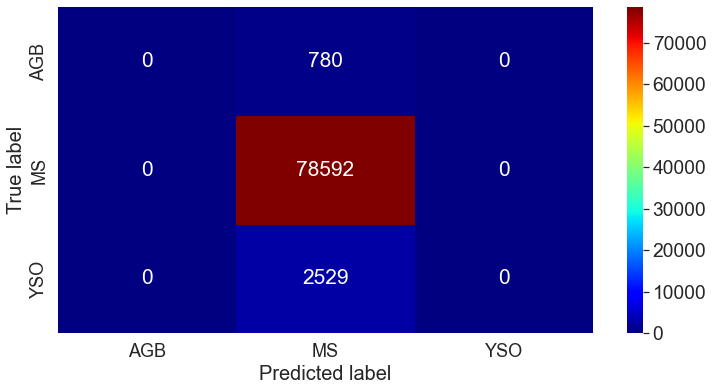

In [39]:
sns.set(font_scale=1.75)
cm = confusion_matrix(y_test, pred)
conf_matrix=pd.DataFrame(
    data=cm,columns=['AGB','MS','YSO'],
    index=['AGB','MS','YSO'])
plt.figure(figsize = (12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="jet")

plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.savefig("final_notebook_plots/rf_conf_mat.png")

plt.show()

In [40]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       780
           1       0.96      1.00      0.98     78592
           2       0.00      0.00      0.00      2529

    accuracy                           0.96     81901
   macro avg       0.32      0.33      0.33     81901
weighted avg       0.92      0.96      0.94     81901



### 3 Bands

In [41]:
X = df1[['W3','K','GaiaDR3_B']]
y = df1[['main_family']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

list_i = []
list_j = []
list_k = []
list_accuracy = []

for i in range(50, 150, 30):
    for j in range(80, 120, 20):
        for k in range(1, 7, 2):
            list_i.append(i)
            list_j.append(j)
            list_k.append(k)
            
            rf_clf = RandomForestClassifier(
                random_state=42, 
                n_estimators = i, 
                max_leaf_nodes = j, 
                max_depth = k
            )
            rf_clf.fit(X_train, y_train)
            pred = rf_clf.predict(X_test)
            list_accuracy.append(np.mean(cross_val_score(rf_clf, X_test, y_test, cv=5)))

In [42]:
class_rf_df_3 = pd.DataFrame({
    "n_estimators":list_i, 
    "max_leaf_nodes":list_j, 
    "max_depth":list_k, 
    "Accuracy":list_accuracy
}).sort_values("Accuracy", ascending = False)

class_rf_df_3.head(5)

,n_estimators,max_leaf_nodes,max_depth,Accuracy
11,80,100,5,0.978706
8,80,80,5,0.978706
5,50,100,5,0.978657
2,50,80,5,0.978657
23,140,100,5,0.978523


In [43]:
rf_clf = RandomForestClassifier(
    random_state=42, 
    n_estimators = class_rf_df_3["n_estimators"][0], 
    max_leaf_nodes = class_rf_df_3["max_leaf_nodes"][0], 
    max_depth = class_rf_df_3["max_depth"][0]
)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)

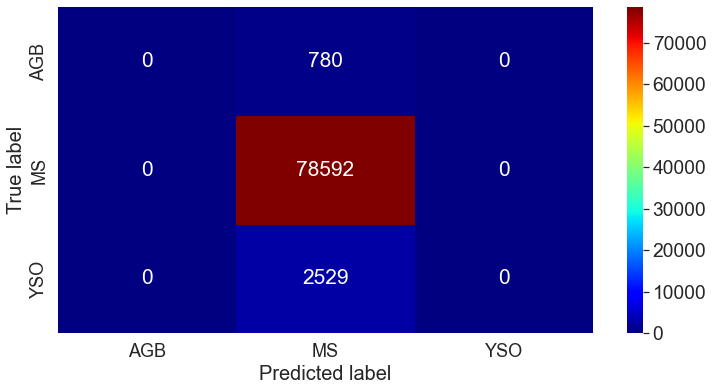

In [44]:
sns.set(font_scale=1.75)
cm = confusion_matrix(y_test, pred)
conf_matrix=pd.DataFrame(
    data=cm,columns=['AGB','MS','YSO'],
    index=['AGB','MS','YSO'])
plt.figure(figsize = (12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="jet")

plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.savefig("final_notebook_plots/rf_all_conf_mat.png")

plt.show()

In [45]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       780
           1       0.96      1.00      0.98     78592
           2       0.00      0.00      0.00      2529

    accuracy                           0.96     81901
   macro avg       0.32      0.33      0.33     81901
weighted avg       0.92      0.96      0.94     81901



These random forest models perform exceedingly poor on our data.

# Conclusion

We have learned a lot as a result of this project. The main challenge has to do with the nature of the data in that there is a very large class imbalance between different objects. For astronomers who are interested in studying the beginning of a star's life (YSO) or the end of a star's life (AGB), the main challenge is locating these objects. YSOs tend to form in clusters, so identifying even one could help identify others. There are three main next steps to take. The first would be to run the models on new data and identify potential YSOs and AGB stars. Another step could be to assess the types of mistakes these models made- perhaps the classification of those objects could be validated. The third step could be to expand the scope and distinguish between the subfamilies of the three main families now that they are more or less separated following these models. 